DELIVERABLE 1: FINDING OPTIMAL NUMBER OF CLUSTERS


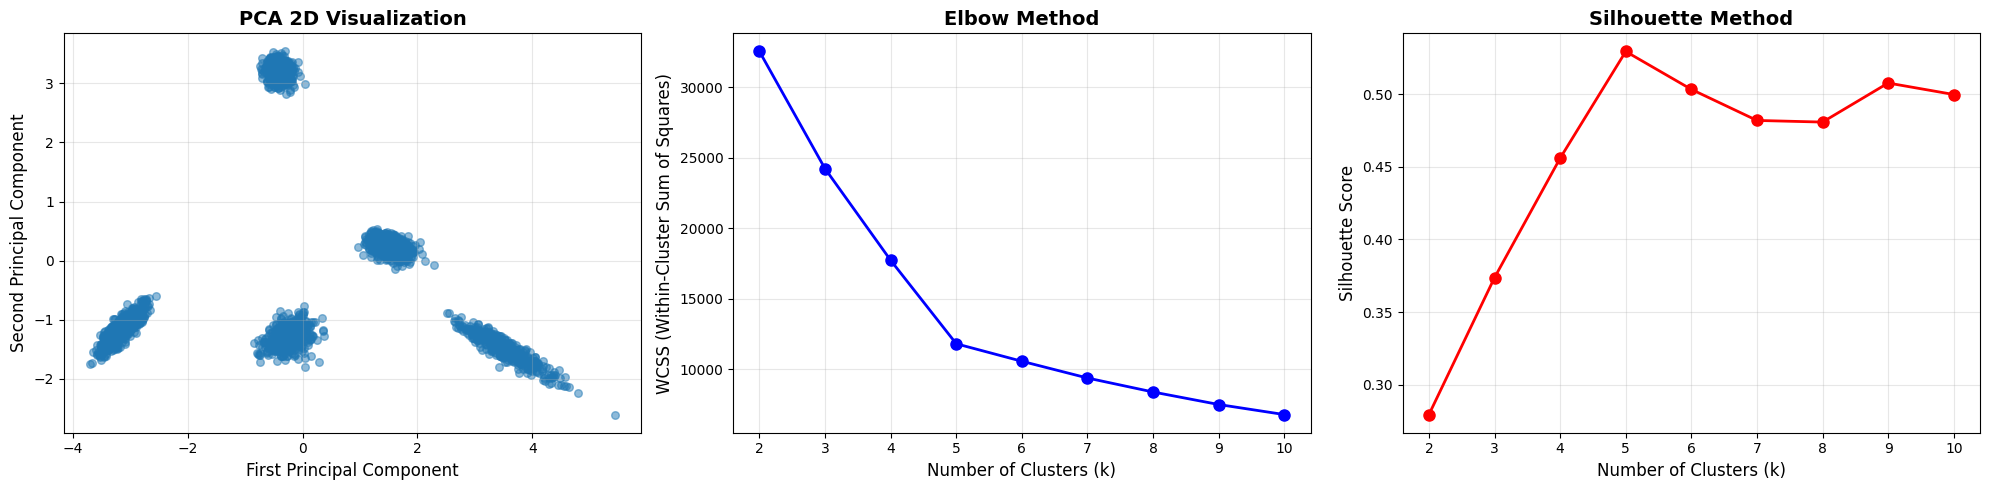


Optimal number of clusters: 5

DELIVERABLE 2: DBSCAN CLUSTERING

Using DBSCAN parameters:
  eps: 2
  min_samples: 10

Number of clusters we found in the first deliverable 5
Silhouette score we found in the second deliverable 0.8943

All of the clusters obtained in the second deliverable | Number of instances
Cluster 0 | 693
Cluster 1 | 411
Cluster 2 | 404
Cluster 3 | 680
Cluster 4 | 547


In [73]:
# IMPORTS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

# =============================================================================
# TRANSFORMERS
# =============================================================================

class DropNaTransformer(BaseEstimator, TransformerMixin):
    """Remove rows with missing values"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.dropna()

class DropDuplicatesTransformer(BaseEstimator, TransformerMixin):
    """Remove duplicate rows"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.drop_duplicates()

class CategoricalEncoderTransformer(BaseEstimator, TransformerMixin):
    """Encode categorical features using One-Hot Encoding"""
    def __init__(self):
        self.encoder = None
        self.categorical_cols = None
        self.numerical_cols = None
    
    def fit(self, X, y=None):
        X_copy = X.copy()
        self.categorical_cols = X_copy.select_dtypes(include=['object']).columns.tolist()
        self.numerical_cols = X_copy.select_dtypes(exclude=['object']).columns.tolist()
        
        if len(self.categorical_cols) > 0:
            self.encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
            self.encoder.fit(X_copy[self.categorical_cols])
        return self
    
    def transform(self, X):
        X_copy = X.copy()
        
        if self.encoder and len(self.categorical_cols) > 0:
            encoded = self.encoder.transform(X_copy[self.categorical_cols])
            encoded_feature_names = self.encoder.get_feature_names_out(self.categorical_cols)
            encoded_df = pd.DataFrame(
                encoded, 
                columns=encoded_feature_names,
                index=X_copy.index
            )
            
            if len(self.numerical_cols) > 0:
                X_transformed = pd.concat([
                    X_copy[self.numerical_cols].reset_index(drop=True), 
                    encoded_df.reset_index(drop=True)
                ], axis=1)
            else:
                X_transformed = encoded_df
            
            return X_transformed
        
        return X_copy

class DataFrameToArrayTransformer(BaseEstimator, TransformerMixin):
    """Convert DataFrame to numpy array for clustering"""
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.values

# =============================================================================
# DELIVERABLE 1: FINDING OPTIMAL NUMBER OF CLUSTERS (KMeans)
# =============================================================================

# Load Data
DATA_PATH = "customer_segments.csv"
df = pd.read_csv(DATA_PATH)

print("="*80)
print("DELIVERABLE 1: FINDING OPTIMAL NUMBER OF CLUSTERS")
print("="*80)

# Create preprocessing pipeline
preprocessing_pipeline = Pipeline(steps=[
    ('drop_na', DropNaTransformer()),
    ('drop_duplicates', DropDuplicatesTransformer()),
    ('encode_categorical', CategoricalEncoderTransformer()),
    ('to_array', DataFrameToArrayTransformer()),
    ('scaler', StandardScaler())
])

# Apply preprocessing
X_scaled = preprocessing_pipeline.fit_transform(df)

# Calculate Elbow Method and Silhouette Scores
k_range = range(2, 11)
wcss = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# PCA for 2D visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

# Plot all three visualizations
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# PCA 2D Visualization
axes[0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], alpha=0.5, s=30)
axes[0].set_xlabel('First Principal Component', fontsize=12)
axes[0].set_ylabel('Second Principal Component', fontsize=12)
axes[0].set_title('PCA 2D Visualization', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Elbow Method
axes[1].plot(k_range, wcss, 'bo-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
axes[1].set_title('Elbow Method', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Silhouette Method
axes[2].plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Silhouette Score', fontsize=12)
axes[2].set_title('Silhouette Method', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.show()

# Find optimal k based on silhouette score
optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
print(f"\nOptimal number of clusters: {optimal_k}")

# =============================================================================
# DELIVERABLE 2: FINAL CLUSTERING PIPELINE WITH DBSCAN
# =============================================================================

print("\n" + "="*80)
print("DELIVERABLE 2: DBSCAN CLUSTERING")
print("="*80)

# Set DBSCAN parameters manually
best_eps = 2
best_min_samples = 10

print(f"\nUsing DBSCAN parameters:")
print(f"  eps: {best_eps}")
print(f"  min_samples: {best_min_samples}")

# Create final pipeline with best parameters
final_pipeline = Pipeline(steps=[
    ('drop_na', DropNaTransformer()),
    ('drop_duplicates', DropDuplicatesTransformer()),
    ('encode_categorical', CategoricalEncoderTransformer()),
    ('to_array', DataFrameToArrayTransformer()),
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=3)),
    ('DBSCAN', DBSCAN(eps=best_eps, min_samples=best_min_samples))
])

# Fit the entire pipeline
final_pipeline.fit(df)

# Get cluster labels
cluster_labels = final_pipeline.named_steps['DBSCAN'].labels_

# Get scaled data for silhouette calculation
X_scaled_final = final_pipeline[:-1].transform(df)

silhouette_final = silhouette_score(X_scaled_final, cluster_labels)

# Calculate Silhouette Score
silhouette_final = silhouette_score(X_scaled_final, cluster_labels)

# Count instances per cluster
unique, counts = np.unique(cluster_labels, return_counts=True)
cluster_counts = dict(zip(unique, counts))

# =============================================================================
# REQUIRED OUTPUT FORMAT
# =============================================================================

print(f"\nNumber of clusters we found in the first deliverable {optimal_k}")
print(f"Silhouette score we found in the second deliverable {silhouette_final:.4f}")
print()
print("All of the clusters obtained in the second deliverable | Number of instances")
for cluster_id in sorted(cluster_counts.keys()):
    print(f"Cluster {cluster_id} | {cluster_counts[cluster_id]}")